In [1]:
from datetime import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt

from imdb import IMDb
import imdb.helpers as imdbHelpers

In [18]:
def episodeToDict(e):
    # Some Series, like Simpsons, have upcoming episodes.
    # The have no air date or rating yet.
    if e.get('original air date', None) is None:
        return None
    
    if e.get('rating', None) is None:
        return None
    
    rawDate = e['original air date']

    try:
        parsedDate = dt.strptime(rawDate, '%d %b %Y')
    except ValueError:
        parsedDate = dt.strptime(rawDate, '%d %b. %Y')
    
    formattedDate = parsedDate.strftime('%Y-%m-%d')
    
    episodeCode = str(e['season']) + '.' + str(e['episode'])
    
    return {
        'title': e['title'], 
        'rating': e['rating'], 
        'date': pd.Timestamp(formattedDate), 
        'season': e['season'],
        'episodeCode': episodeCode,
        'episode': e['episode']
    }

def add_season_to_plot(plot, seasonsCount, season, data, seriesTitle=None, ymin=0, ymax=10, showGrid=True):
    filtredData = data[(data.season == season)]
    
    plotRows = seasonsCount / 2 + 1
    
    subplot = plot.add_subplot(plotRows, 2, season)
    subplot.grid(showGrid)
    subplot.set_ylim(ymin - 0.2, ymax + 0.2)
    
    title = '${} — Season # ${:d}'.format(seriesTitle, season)
    subplot.set_title(title)
    
    subplot.tick_params(axis='x', labelrotation=0)

    for index, row in filtredData.iterrows():
        label = '{:.2f}'.format(row.rating)
        subplot.text(row.episode, row.rating, label, rotation=0, rotation_mode='anchor')

    subplot.plot(filtredData.episode, filtredData.rating, 'r-')
    subplot.plot(filtredData.episode, filtredData.rating, 'b+')

In [3]:
ia = IMDb(accessSystem='https')

# MASH - 0068098
# Friends - 0108778
# X-Files - 0106179
# Seinfield - 0098904
# Simpsons - 0096697
# Futurama - 0149460
series = ia.get_movie('0149460', info=('main', 'episodes'))

In [4]:
episodes = imdbHelpers.sortedEpisodes(series)

In [7]:
rawEpisodesList = list(map(episodeToDict, episodes))

episodesList = [e for e in rawEpisodesList if e is not None]

In [8]:
dataFrame = pd.DataFrame(episodesList)

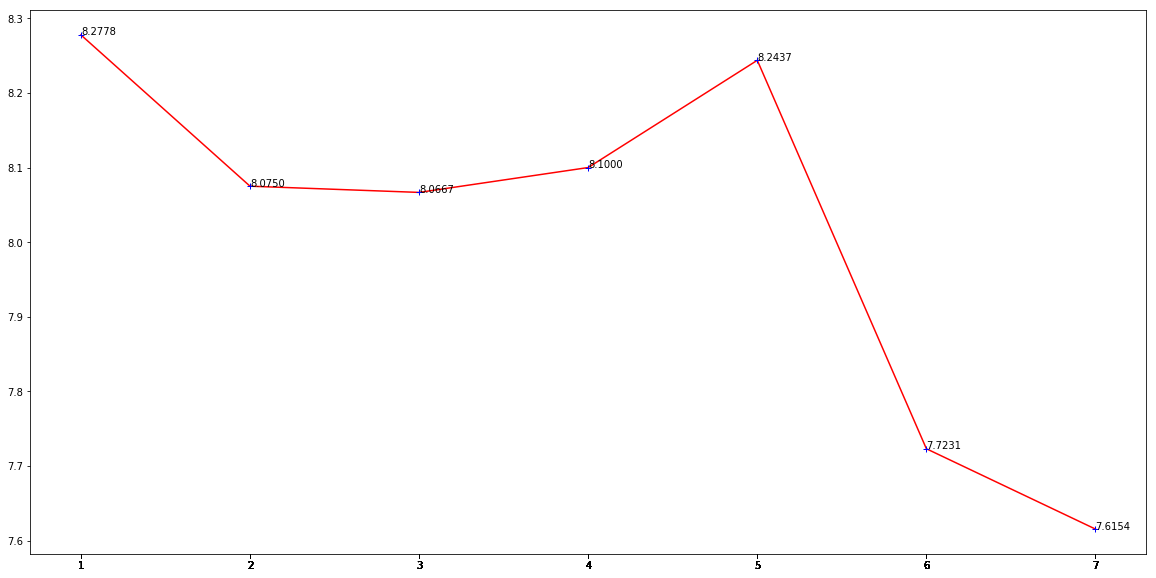

In [29]:
meanBySeason = dataFrame.groupby([dataFrame.season]).agg('mean')[['rating']]

meanRatingPlot = plt.figure(figsize=(20,10))
meanRatingSubplot = meanRatingPlot.add_subplot(1,1,1)
meanRatingSubplot.set_xticks(dataFrame.season)

meanRatingSubplot.plot(meanBySeason, 'r-')
meanRatingSubplot.plot(meanBySeason, 'b+')

for index, row in meanBySeason.iterrows():
    label = "{:.4f}".format(row.rating)
    meanRatingSubplot.text(row.name, row.rating, label)

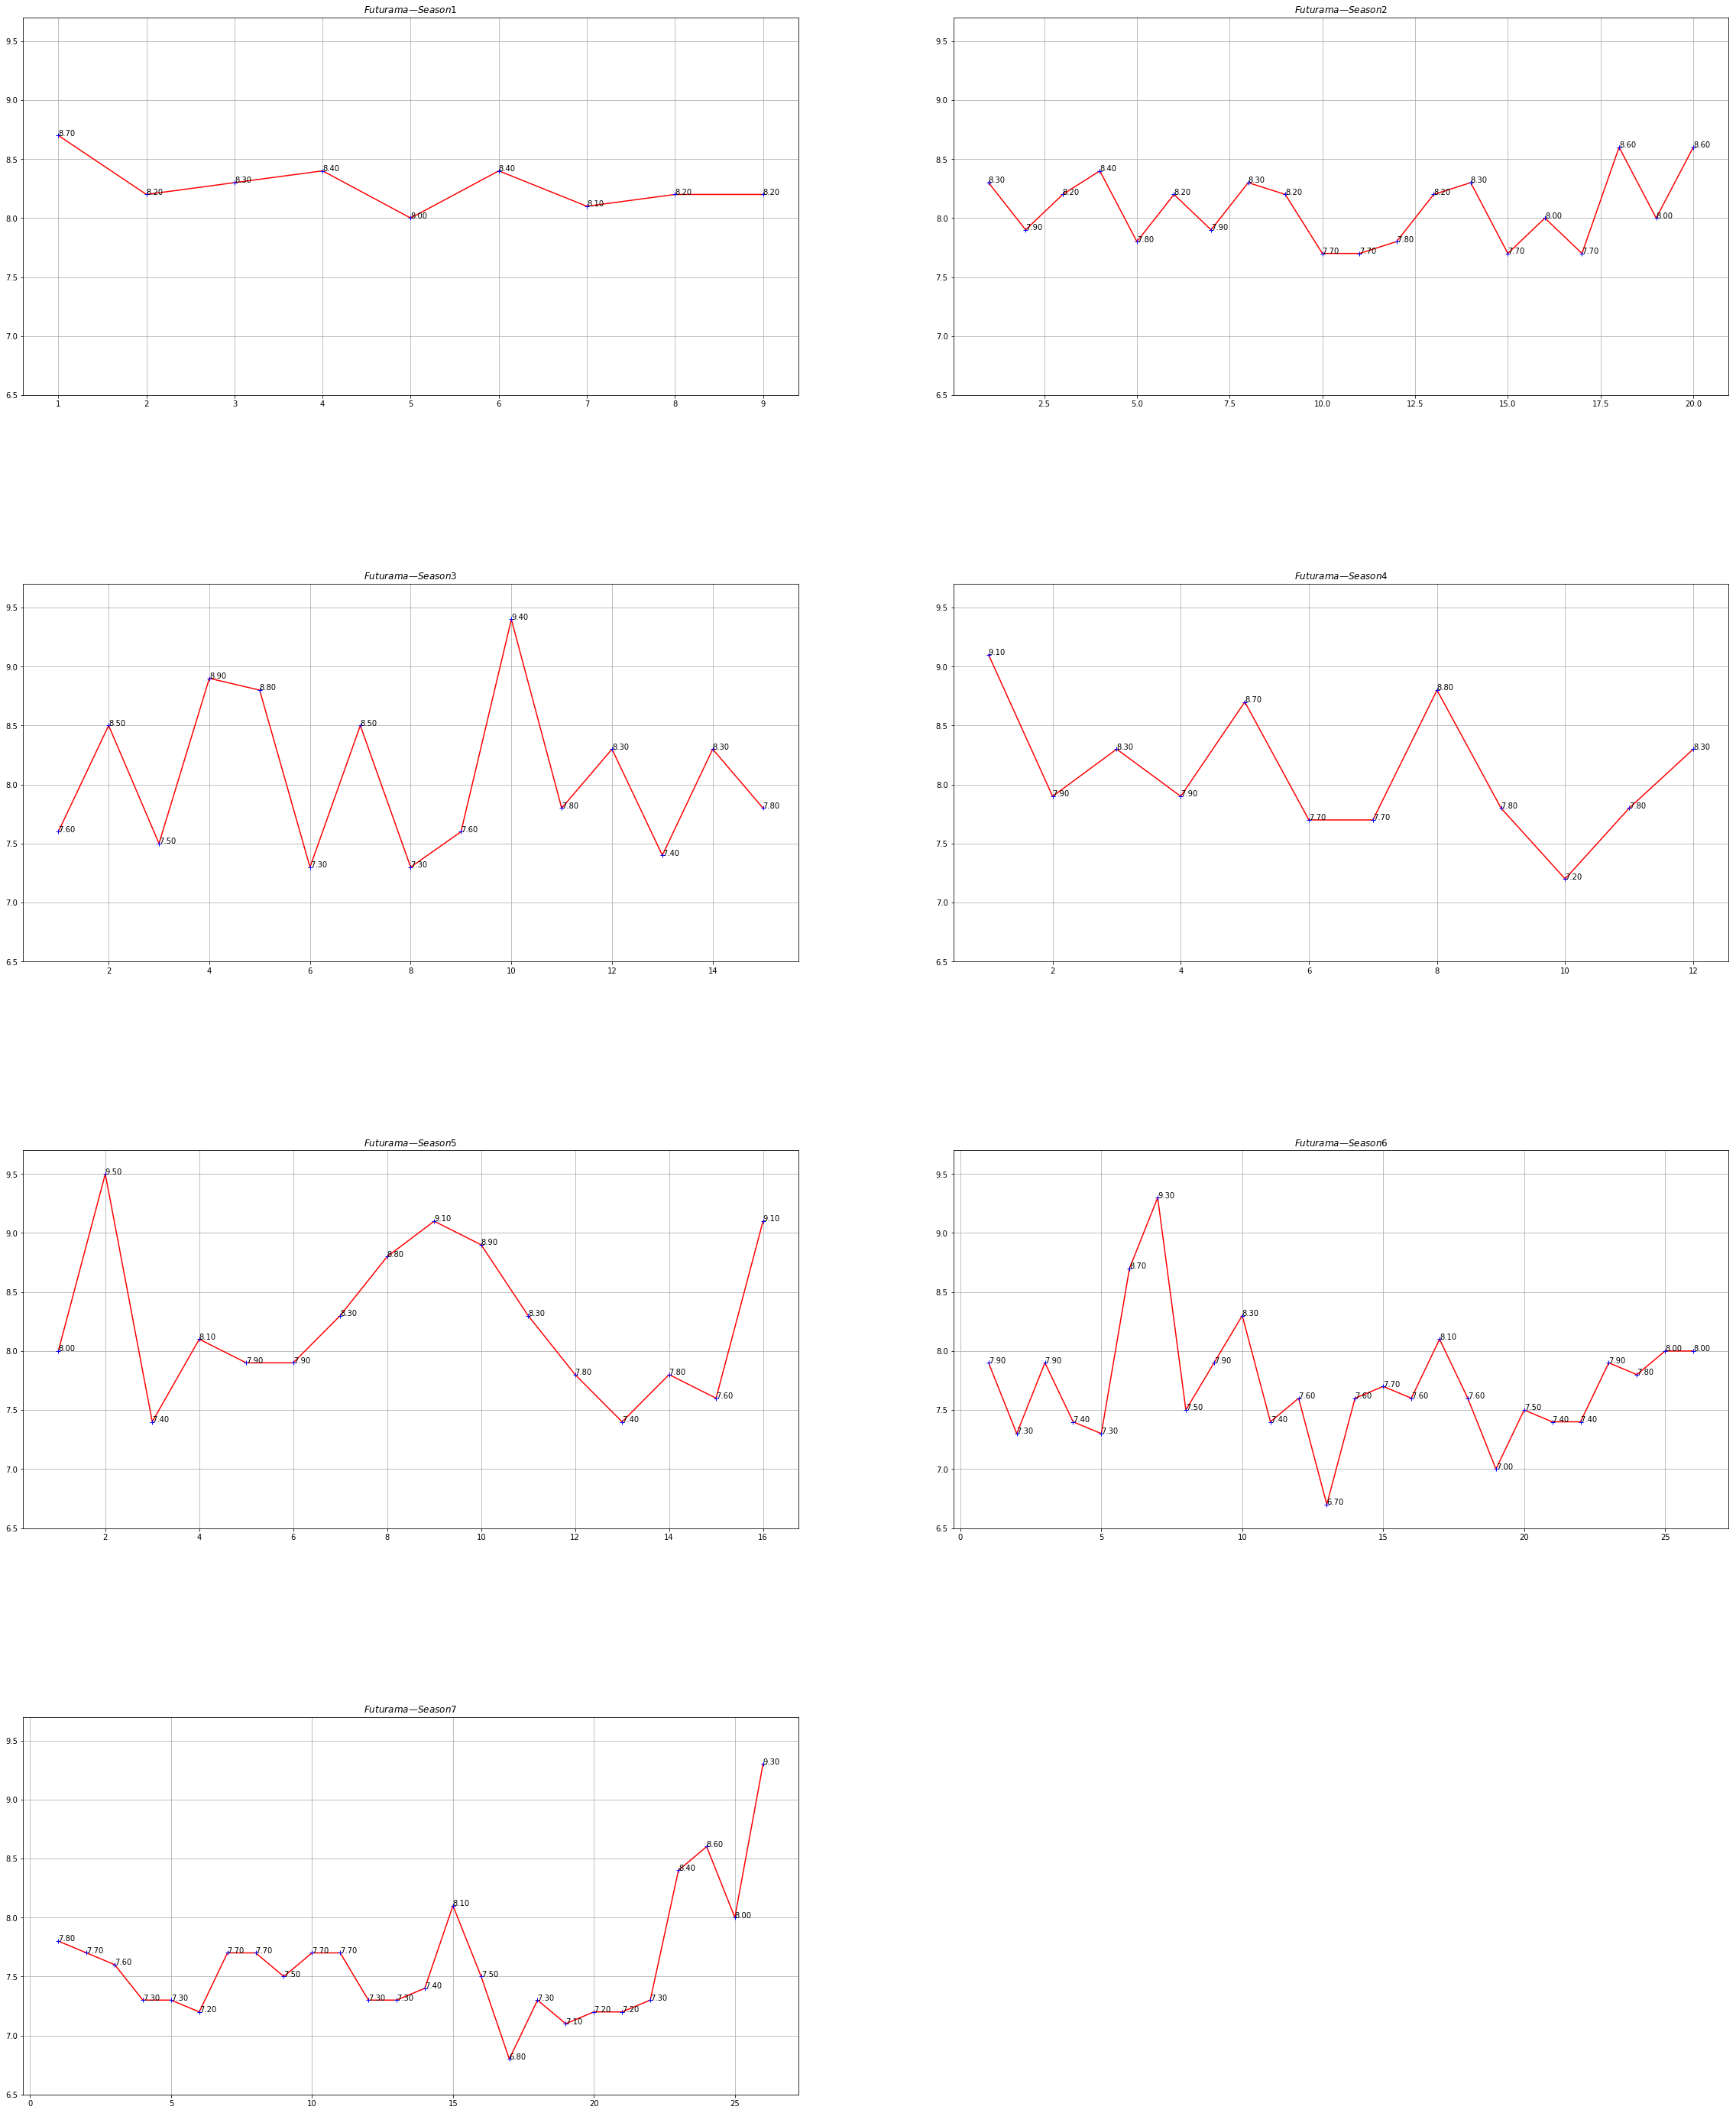

In [22]:
seasonsPlot = plt.figure(figsize=(40,50))
seasonsPlot.subplots_adjust(hspace=0.5)

minRating = dataFrame.rating.min() 
maxRating = dataFrame.rating.max() 
uniqueSeasonsNumbers = dataFrame.season.unique()
seriesTitle = series['smart canonical title']

for seasonNumber in uniqueSeasonsNumbers:
    add_season_to_plot(seasonsPlot, len(uniqueSeasonsNumbers), seasonNumber, dataFrame, seriesTitle=seriesTitle, ymin=minRating, ymax=maxRating)